In [1]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from statsmodels.stats import diagnostic
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm
import scipy.stats as stats 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.decomposition import PCA


import warnings
warnings.simplefilter('ignore')

In [2]:
vehicles = pd.read_csv('./cars.csv')

In [3]:
vehicles.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


# Data Cleaning

In [4]:
# Column cleaning
vehicles_cleaned = vehicles.copy(deep=True)
vehicles_cleaned.columns = vehicles_cleaned.columns.str.strip().str.lower()

def company_column(row):
    row = row.lower()
    new_row = row.split(' ')[0]
    
    if new_row == 'land':
        return 'Land Rover'
    else:
        return new_row.capitalize()
    
# Creating column company
vehicles_cleaned = vehicles_cleaned.drop(['new_price', 'unnamed: 0'], axis=1)
vehicles_cleaned['company'] = vehicles_cleaned['name'].apply(company_column)




Unnamed: 0                        5893
Name                 Maruti Estilo LXI
Location                       Chennai
Year                              2008
Kilometers_Driven                51000
Fuel_Type                       Petrol
Transmission                    Manual
Owner_Type                      Second
Mileage                      19.5 kmpl
Engine                         1061 CC
Power                         null bhp
Seats                              NaN
New_Price                          NaN
Price                             1.75
Name: 5893, dtype: object

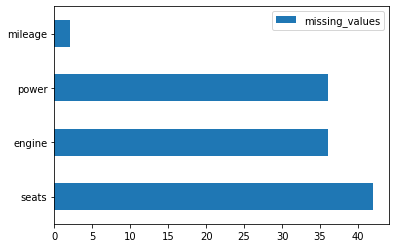

In [5]:
vehicles_cleaned.isnull().sum().to_frame(name='missing_values')\
.query('missing_values > 0').sort_values(by='missing_values', ascending=False).plot.barh();

vehicles.iloc[5893]

In [6]:
null_values = vehicles_cleaned.isnull().sum()
null_columns = null_values[null_values.values >0]
(null_columns.sort_values() / vehicles_cleaned.shape[0]) * 100

mileage    0.033228
engine     0.598106
power      0.598106
seats      0.697790
dtype: float64

In [7]:
vehicles_cleaned = vehicles_cleaned.dropna()

In [8]:
# Cleaning mileage, engine and power company 

def strings_converter(row):
    row = str(row)
    return re.sub('[^0-9,.]', '', row)

indexes = vehicles_cleaned[vehicles_cleaned['power'] == 'null bhp'].index
vehicles_cleaned.drop(indexes, axis=0, inplace=True)
columns_to_clean = ['mileage', 'engine', 'power']

for column in columns_to_clean:
    vehicles_cleaned[column] = vehicles_cleaned[column].apply(strings_converter)
    if column != 'engine':
        vehicles_cleaned[column] = vehicles_cleaned[column].astype(float)
    else:
        vehicles_cleaned[column] = vehicles_cleaned[column].astype(int)

vehicles_cleaned.reset_index(inplace=True, drop=True)
vehicles_cleaned['seats'] = vehicles_cleaned['seats'].astype(int)


vehicles_cleaned.drop(3969, axis=0, inplace=True)







In [9]:
vehicles_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5871 entries, 0 to 5871
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5871 non-null   object 
 1   location           5871 non-null   object 
 2   year               5871 non-null   int64  
 3   kilometers_driven  5871 non-null   int64  
 4   fuel_type          5871 non-null   object 
 5   transmission       5871 non-null   object 
 6   owner_type         5871 non-null   object 
 7   mileage            5871 non-null   float64
 8   engine             5871 non-null   int64  
 9   power              5871 non-null   float64
 10  seats              5871 non-null   int64  
 11  price              5871 non-null   float64
 12  company            5871 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 642.1+ KB


In [10]:
numeric_columns = vehicles_cleaned._get_numeric_data().columns.tolist() 
df_num = vehicles_cleaned[numeric_columns].copy()
df_num

,year,kilometers_driven,mileage,engine,power,seats,price
0,2010,72000,26.60,998,58.16,5,1.75
1,2015,41000,19.67,1582,126.20,5,12.50
2,2011,46000,18.20,1199,88.70,5,4.50
3,2012,87000,20.77,1248,88.76,7,6.00
4,2013,40670,15.20,1968,140.80,5,17.74
...,...,...,...,...,...,...,...
5867,2014,27365,28.40,1248,74.00,5,4.75
5868,2015,100000,24.40,1120,71.00,5,4.00
5869,2012,55000,14.00,2498,112.00,8,2.90
5870,2013,46000,18.90,998,67.10,5,2.65


In [11]:
categoric_columns = vehicles_cleaned.drop(columns=numeric_columns).columns.tolist()
df_categ = vehicles_cleaned[categoric_columns].copy()
df_categ.head()

,name,location,fuel_type,transmission,owner_type,company
0,Maruti Wagon R LXI CNG,Mumbai,CNG,Manual,First,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,Diesel,Manual,First,Hyundai
2,Honda Jazz V,Chennai,Petrol,Manual,First,Honda
3,Maruti Ertiga VDI,Chennai,Diesel,Manual,First,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,Diesel,Automatic,Second,Audi


(0.1202534170458267, 0.0009999999999998899)


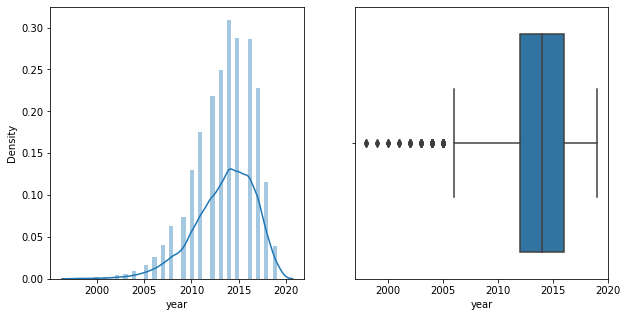


(0.2705739339841924, 0.0009999999999998899)


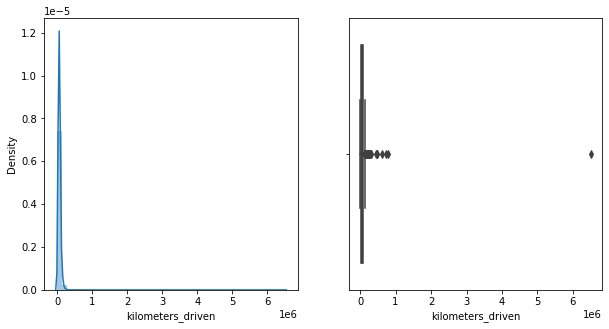


(0.029960142052226302, 0.0009999999999998899)


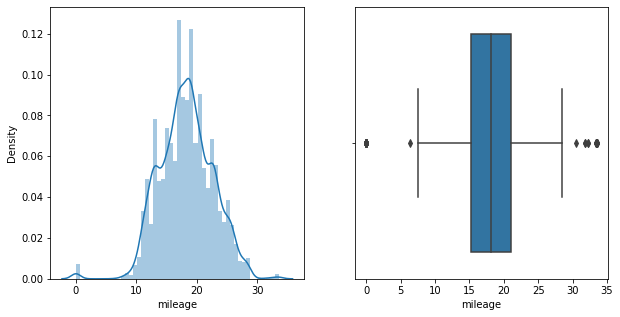


(0.1897363278766454, 0.0009999999999998899)


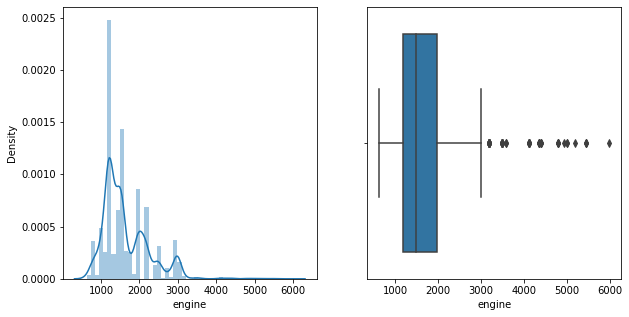


(0.16099698226373071, 0.0009999999999998899)


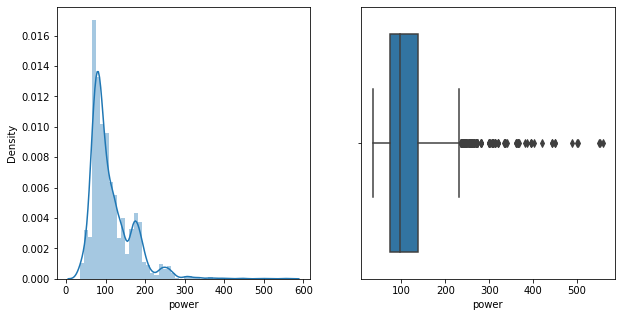


(0.4945010759727685, 0.0009999999999998899)


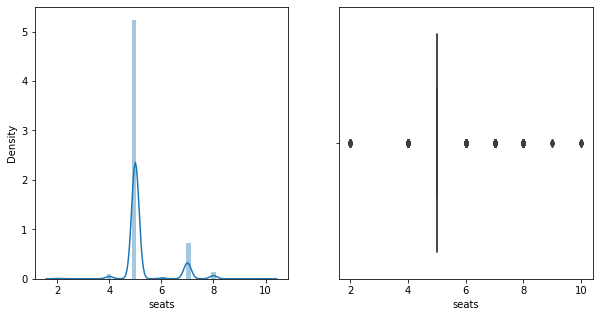


(0.24142951121434492, 0.0009999999999998899)


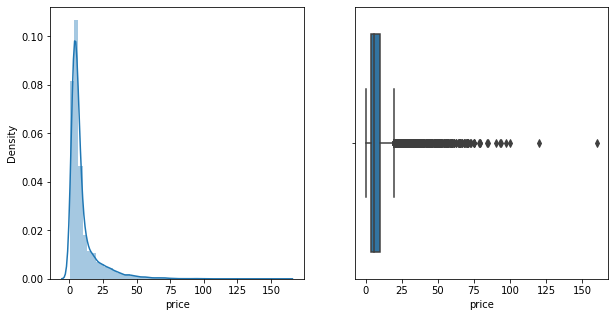

In [12]:
for columna in df_num:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df_num[columna], kde=True, ax=ax[0])
    sns.boxplot(df_num[columna], orient='h', ax=ax[1])
    print(diagnostic.kstest_normal(df_num[columna]))
    plt.show()
    print('');

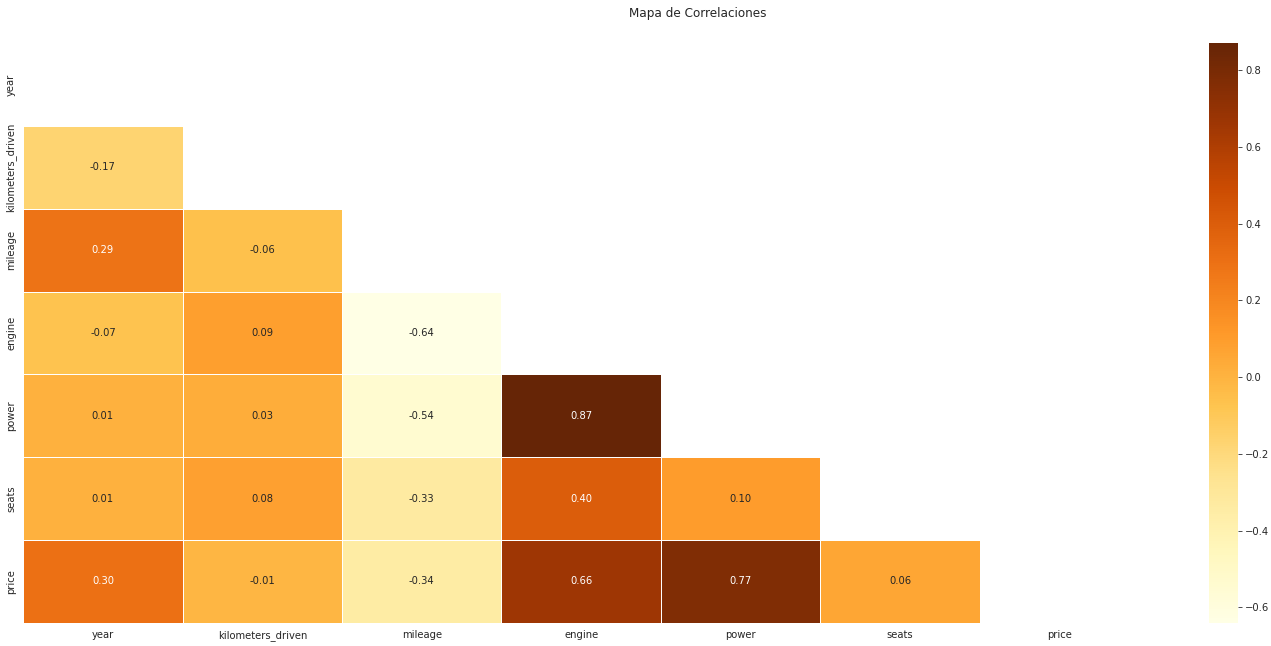

In [13]:
num_corr = df_num.corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(round(num_corr, 2), annot=True, ax=ax, cmap='YlOrBr',
              fmt='.2f', linewidths=0.5, mask=mask)
    fig.subplots_adjust(top=0.93)
    fig.suptitle('Mapa de Correlaciones')

In [14]:
diesel_vehicles = vehicles_cleaned[vehicles_cleaned['fuel_type'] == 'Diesel']

from statsmodels.stats.weightstats import ztest
vehicles_cleaned[vehicles_cleaned['year']==2018]['mileage']
ztest(vehicles_cleaned[vehicles_cleaned['year']==2016]['mileage'], value=vehicles_cleaned['mileage'].mean() )
# ztest(Rushing_Offense[Rushing_Offense['Years'] == 2021]['TD'], value=Rushing_Offense['TD'].mean(), alternative='larger')



(8.510235929774987, 1.735797954544536e-17)

In [15]:
vehicles_cleaned['location'].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

In [16]:
vehicles_cleaned['company'].value_counts()
brands = vehicles_cleaned['company'].value_counts().index
brands[:10]

ten_sold= vehicles_cleaned[vehicles_cleaned['company'].isin( brands[:10])]
ten_sold= vehicles_cleaned[vehicles_cleaned['company'].isin( brands[:10])]
ten_sold

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,company
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998,58.16,5,1.75,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5,17.74,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5866,Honda Amaze VX i-DTEC,Coimbatore,2015,70602,Diesel,Manual,First,25.80,1498,98.60,5,4.83,Honda
5867,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.40,1248,74.00,5,4.75,Maruti
5868,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120,71.00,5,4.00,Hyundai
5869,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498,112.00,8,2.90,Mahindra


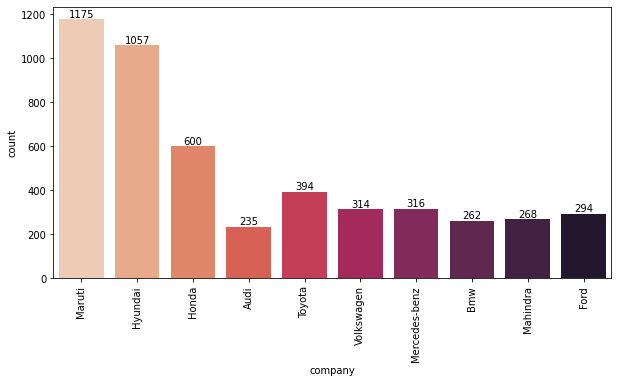

In [17]:

plt.figure(figsize = (10, 5))
plot = sns.countplot(x = 'company', data = ten_sold, palette='rocket_r')
sns.color_palette("magma", as_cmap=True)
plt.xticks(rotation = 90)
for p in plot.patches:
     plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')


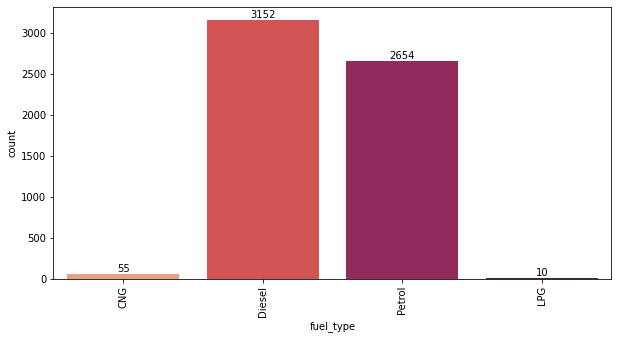

In [18]:
plt.figure(figsize = (10, 5))
plot = sns.countplot(x = 'fuel_type', data = vehicles_cleaned, palette='rocket_r')
plt.xticks(rotation = 90)
for p in plot.patches:
     plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

Nombre de Columna:  location
Mumbai        774
Hyderabad     718
Kochi         645
Coimbatore    629
Pune          594
Delhi         545
Kolkata       521
Chennai       476
Jaipur        402
Bangalore     347
Ahmedabad     220
Name: location, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


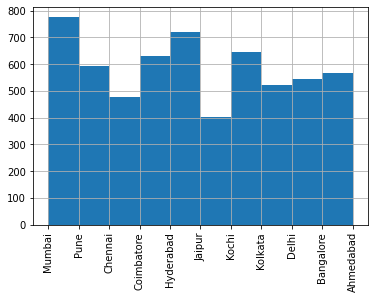

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  fuel_type
Diesel    3152
Petrol    2654
CNG         55
LPG         10
Name: fuel_type, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


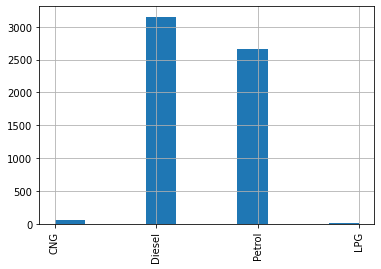

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  transmission
Manual       4169
Automatic    1702
Name: transmission, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


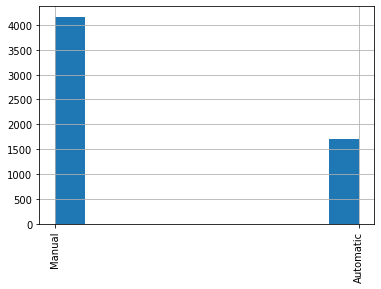

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  owner_type
First             4838
Second             925
Third              101
Fourth & Above       7
Name: owner_type, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


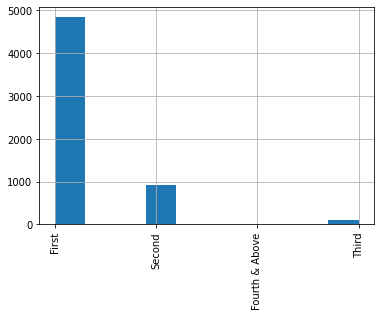

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  company
Maruti           1175
Hyundai          1057
Honda             600
Toyota            394
Mercedes-benz     316
Volkswagen        314
Ford              294
Mahindra          268
Bmw               262
Audi              235
Tata              183
Skoda             172
Renault           145
Chevrolet         120
Nissan             89
Land Rover         57
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               23
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Isuzu               3
Force               3
Ambassador          1
Bentley             1
Lamborghini         1
Name: company, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


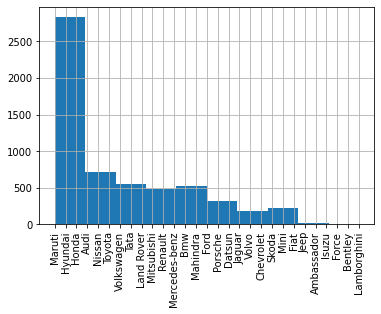

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [19]:
for column in df_categ:
    if column != "name":
        print(f'Nombre de Columna: ', column)
        print(df_categ[column].value_counts())
        print(df_categ[column].hist(xrot=90))
        plt.show()
        print('~~~'*20)

In [20]:
df_categ_dummies = pd.get_dummies(df_categ.drop(columns=['name', 'location']))
df_categ_dummies.head() 

# sckit standard scaler 
# var num

,fuel_type_CNG,fuel_type_Diesel,fuel_type_LPG,fuel_type_Petrol,transmission_Automatic,transmission_Manual,owner_type_First,owner_type_Fourth & Above,owner_type_Second,owner_type_Third,...,company_Mini,company_Mitsubishi,company_Nissan,company_Porsche,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Anova Fuel test

formula = 'price ~ C(fuel_type)'
model = ols(formula=formula, data=vehicles_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

'''Se rechaza la hipotesis de nula para la ANOVA
H0:  μ1=μ2=μ3, la variable fuel_type tiene 
un impacto en el valor de la compra de un auto usado
'''
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(fuel_type),3.0,76900.858011,25633.619337,225.807272,1.214845e-138
Residual,5867.0,666021.263392,113.519902,NaN,NaN


In [77]:
year_2019_mileage = vehicles_cleaned[vehicles_cleaned['year']==2019]['mileage']
ztest(year_2019_mileage, value=vehicles_cleaned['mileage'].mean()) 

year_2019_mileage

67       0.00
131     17.00
150     21.10
168     18.90
226     11.36
        ...  
5628    23.84
5648    25.17
5664    15.41
5719    16.55
5732     0.00
Name: mileage, Length: 102, dtype: float64

<AxesSubplot:>

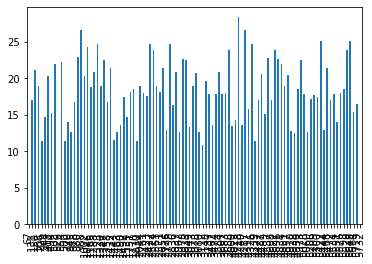

In [79]:
year_2019_mileage.plot(kind='bar')

In [22]:
data = pd.concat([df_num, df_categ_dummies], axis=1)

data.shape

(5871, 46)

In [23]:
X = df_num.drop(columns=['price', 'engine'])
y = df_num[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

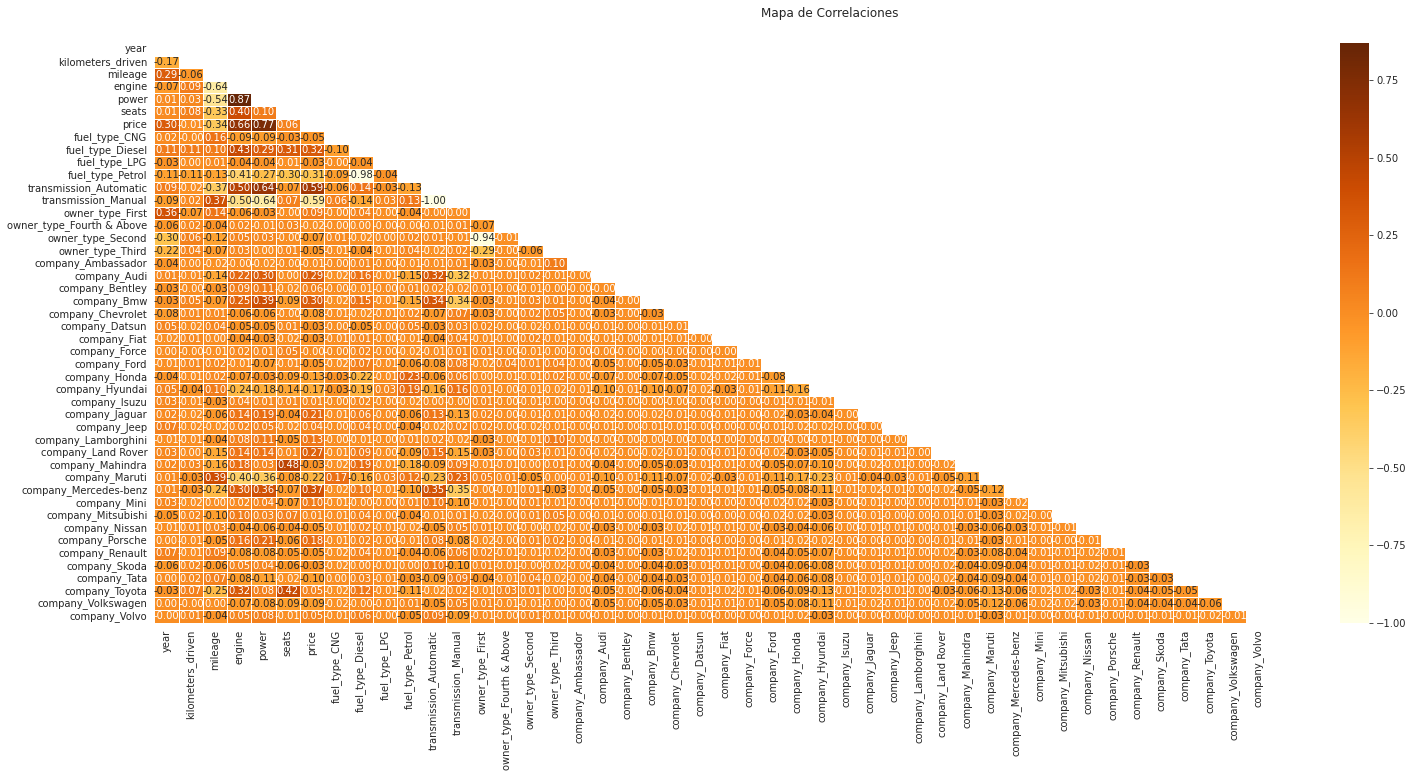

In [73]:
data = pd.concat([df_num, df_categ_dummies], axis=1)
data_corr = data.corr()
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(round(data_corr, 2), annot=True, ax=ax, cmap='YlOrBr',
              fmt='.2f', linewidths=0.5, mask=mask)
    fig.subplots_adjust(top=0.93)
    fig.suptitle('Mapa de Correlaciones')

In [25]:
ten_largest = data.corr().nlargest(10, 'price')['price'].index
X = sm.add_constant(data[ten_largest].drop(columns=['price', 'engine']))
y = data['price']

# X_train, X_test, y_train, y_test = train_test_split(data[ten_largest].drop(columns=['price', 'engine']), y, test_size=0.2)

In [26]:
modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     2009.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        15:27:19   Log-Likelihood:                -18666.
No. Observations:                5871   AIC:                         3.735e+04
Df Residuals:                    5862   BIC:                         3.741e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1988

In [27]:
# Ttest Cualquier parámetro H0: Bj = 0 , Ha: Bj != 0
# Ftest H0 = B1 = B2, ..., Bn = 0, Ha H0 = B1 = B2, ..., Bn != 0

# Con base en la información del modelo, el p-value de los estadísticos t de todas las variables es menor al 0.05 esto implica que las variables son significativas. 
# Asimismo, el R^2 es alto, las variables independientes explican  en un 98% las variaciones de la variable dependiente. 
# El p-value del estadistico F es menor a 0.05, lo que indica que el modelo se ajusta mejor a los datos.
# # Se rechaza la hipótesis que todos los coeficientes de la regresión son iguales a 0

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data[ten_largest].drop(columns=['price', 'engine']), y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# sns.set()
# plt.scatter(y_train_predict, y_train, c='blue');
# X_train[X_train['company_Bmw'] == 1]

In [29]:
intercept = model.intercept_
intercept

-1978.5079745598523

In [30]:
# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)

# sns.set()
# plt.scatter(y_train_predict, y_train, c='blue');

In [31]:
y_train.values.flatten()

array([12.5 ,  1.2 ,  6.24, ...,  7.5 ,  7.3 , 11.78])

In [32]:
y_train_predict

array([20.71951903, -2.29112416,  7.50079872, ...,  8.35809054,
        9.33375997, 13.02061287])

In [33]:
df_y = pd.DataFrame(zip(y_train.values.flatten(), y_train_predict),
                    columns=['y_observada', 'y_predicha'])
df_y

,y_observada,y_predicha
0,12.50,20.719519
1,1.20,-2.291124
2,6.24,7.500799
3,16.00,16.321915
4,4.90,7.623748
...,...,...
4691,2.10,-0.105357
4692,3.95,2.591342
4693,7.50,8.358091
4694,7.30,9.333760


In [34]:
df_y['error'] = df_y['y_observada'] - df_y['y_predicha']
df_y.head()

print(df_y['y_observada'].values)


[12.5   1.2   6.24 ...  7.5   7.3  11.78]


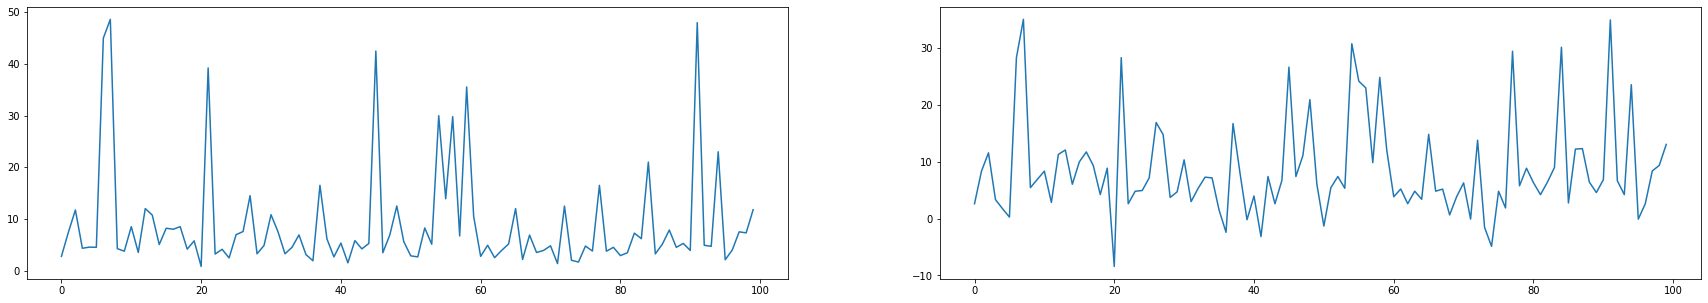

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,5))
ax1.plot(df_y.loc[4596:,'y_observada'].values,)
ax2.plot(df_y.loc[4596:,'y_predicha'].values,)


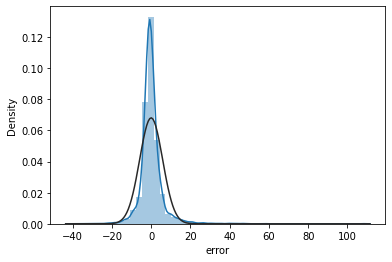

In [36]:
sns.distplot(df_y['error'], fit=norm);

In [37]:
# Raíz del error cuadrático medio
mse(y_train, y_train_predict) ** 0.5

5.856868947651242

In [38]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.7293284998763239, 0.7448385817949241)

In [39]:
mean_absolute_percentage_error(y_test_predict, y_test)

1.4988988814206938

In [40]:
modelLasso = Lasso(alpha=0.02).fit(X_train, y_train)
y_predict_lasso = modelLasso.predict(X_test)

y_predict_lasso




array([25.82186908, 34.08106865, 12.8670713 , ...,  6.27226198,
        3.83121549,  6.03797132])

In [41]:
lasso_loss = mse(y_test, y_predict_lasso)
print("Lasso Loss: ", lasso_loss)

print("="*32)
print("Coef LASSO")
print(modelLasso.coef_)
    


Lasso Loss:  32.31390653423278
Coef LASSO
[ 0.12820342  1.3101277   6.03906978  1.34966044  2.35562195  0.97517449
  4.31575928 17.89620742]


In [42]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data[ten_largest])
data_std

array([[-0.6982968 , -1.02312491, -1.04361195, ..., -1.09913716,
        -0.20419657, -0.09901475],
       [ 0.25733999,  0.23971278, -0.07286813, ...,  0.48093979,
        -0.20419657, -0.09901475],
       [-0.45383157, -0.45629565, -0.7095032 , ..., -0.78312177,
        -0.20419657, -0.09901475],
       ...,
       [-0.59606588, -0.02384241,  1.4497369 , ..., -0.46710638,
        -0.20419657, -0.09901475],
       [-0.61828999, -0.8571965 , -1.04361195, ..., -0.15109099,
        -0.20419657, -0.09901475],
       [-0.63162446, -1.03351863, -1.14667037, ..., -0.78312177,
        -0.20419657, -0.09901475]])

In [43]:
df = pd.DataFrame(X_train, index=X_train.index, columns=X_train.columns)
df.head()

,power,transmission_Automatic,company_Mercedes-benz,fuel_type_Diesel,company_Bmw,year,company_Audi,company_Land Rover
3809,170.0,1,1,1,0,2010,0,0
677,92.7,0,0,0,0,2006,0,0
1214,74.0,0,0,1,0,2017,0,0
5513,168.5,0,0,1,0,2014,0,0
3869,98.6,0,0,1,0,2014,0,0


In [44]:
pca = PCA()
pca.fit(X_train)

PCA()

In [45]:
len(pca.explained_variance_ratio_ )

8

In [46]:
sum(pca.explained_variance_ratio_)

0.9999999999999999

In [57]:
# plt.figure(figsize=(12, 5))
# plt.plot(range(1, 10), pca.explained_variance_ratio_.cumsum(), marker='o',
#          linestyle='--')
# plt.title('Suma acumulada de la varianza explicada')
# plt.xlabel('Número de componentes')
# plt.ylabel('Varianza explicada');

In [48]:
pca = PCA(n_components=4)
pca.fit(X_train)

PCA(n_components=4)

In [49]:
pca.components_

array([[ 9.99979428e-01,  5.34260438e-03,  1.42477921e-03,
         2.67765831e-03,  1.46729907e-03,  3.57753321e-04,
         1.03179034e-03,  2.33502834e-04],
       [ 4.57975815e-04, -1.05627001e-02,  4.03517766e-04,
        -1.77767653e-02,  2.55933793e-03, -9.99782132e-01,
        -3.36716529e-04, -1.03382845e-03],
       [ 2.12819179e-03,  1.06582401e-01,  7.17805419e-03,
        -9.93644443e-01, -1.77895796e-02,  1.65178091e-02,
        -2.39920091e-02, -9.48338459e-03],
       [ 5.91311040e-03, -9.75653592e-01, -1.30725792e-01,
        -1.00898222e-01, -8.64404999e-02,  1.18932906e-02,
        -1.12237542e-01, -2.41814586e-02]])

In [50]:
pca_transform = pca.transform(X_train)
pca_transform[:10]

array([[ 5.62020746e+01,  3.51376601e+00, -3.15720218e-01,
        -5.64078982e-01],
       [-2.11072112e+01,  7.50542896e+00,  3.33583309e-01,
         1.38542028e-01],
       [-3.98002136e+01, -3.51851541e+00, -5.18162421e-01,
         5.78948384e-02],
       [ 5.46967691e+01, -4.75890296e-01, -3.66601724e-01,
         5.81003899e-01],
       [-1.52017929e+01, -5.07902806e-01, -5.15362330e-01,
         1.67677482e-01],
       [-3.97994981e+01, -5.51807967e+00, -4.85126803e-01,
         8.16814196e-02],
       [-1.37954059e+01, -3.51717074e+00, -3.56247034e-01,
        -7.64017883e-01],
       [-4.67048958e+01,  2.49479412e+00,  3.61690644e-01,
         4.66328546e-02],
       [-4.28008674e+01, -1.52032507e+00, -5.57582615e-01,
         1.63689259e-02],
       [-2.53005119e+01, -3.51187476e+00, -4.87303640e-01,
         1.43634939e-01]])

In [51]:
data_pca = pd.DataFrame(pca_transform, index=X_train.index, 
                        columns=['PC1', 'PC2', 'PC3', 'PC4'])
data_pca.head(10)

,PC1,PC2,PC3,PC4
3809,56.202075,3.513766,-0.315720,-0.564079
677,-21.107211,7.505429,0.333583,0.138542
1214,-39.800214,-3.518515,-0.518162,0.057895
5513,54.696769,-0.475890,-0.366602,0.581004
3869,-15.201793,-0.507903,-0.515362,0.167677
988,-39.799498,-5.518080,-0.485127,0.081681
2622,-13.795406,-3.517171,-0.356247,-0.764018
4125,-46.704896,2.494794,0.361691,0.046633
1805,-42.800867,-1.520325,-0.557583,0.016369
2420,-25.300512,-3.511875,-0.487304,0.143635


In [52]:
model = LinearRegression()
model.fit(data_pca, y_train)

y_train_predict = model.predict(data_pca)
y_test_predict = model.predict(data_pca)


In [53]:
model.score(data_pca, y_train)

0.6916627003980513